## Modelo de Predicción de KARBE Ingenio Mante

El presente modelo se puede utilizar para realizar predicciones sobre el valor de KARBE/TCN en función del DIA DE ZAFRA.

Se selecciona dependencia sobre el DIA DE ZAFRA y no sobre la FECHA para aislar variaciones provenientes de la calidad de caña, programas de madurante, programas de cosecha, etc., que se ajustan para el arranque de zafra.

### Selección de Modelo
Se seleccionó un **Proceso Gaussiano** no-paramétrico para encontrar una familia de funciones para aproximar el valor del *KARBE* en función de los días de zafra. Esto pues, a diferencia de una Serie de Tiempo, ayuda a aprovechar la periodicidad del comportamiento del KARBE entre zafras, y adicionalmente a interpolar cualquier DIA DE ZAFRA.

Para este modelo no-paramétrico se realizó una regresión de proceso Gaussiano sobre distintas zafras, utilizando un Kernel RBF para observaciones "ruidosas" (RBF + WK). El modelo se entrena con el conjunto completo de observaciones.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK

%matplotlib inline

In [2]:
# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n\n%s" % gp.kernel_
    s2 = "\n\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    print(s1 + s2 + '\n')

### Dataset KARBE
Este dataset contiene información diaria del KARBE/TCN para las Zafras **20-21, 21-22 y 22-23**. 

El **KARBE** se refiere a los *Kilogramos de Azúcar Recuperables Base Estándar* que se obtienen de un peso de caña especificado.
- KARBE/TCN contiene información del KARBE sobre Toneladas de Caña en Peso NETO (Total - Trash).

In [3]:
df_all = pd.read_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Karbe\Karbe_Mante.csv')
df_all

,Zafra,Dia Zafra,Fecha,Pol % Caña,KARBE/TCN
0,2021,1,11/11/2020,12.812198,120.439667
1,2021,2,1/12/2020,13.117811,121.566044
2,2021,3,11/13/2020,13.661457,126.959646
3,2021,4,11/14/2020,13.386675,124.834124
4,2021,5,11/15/2020,13.348486,124.332142
...,...,...,...,...,...
422,2023,70,2/15/2023,13.966597,130.618670
423,2023,71,2/16/2023,14.858260,138.912612
424,2023,72,2/17/2023,14.244178,132.703114
425,2023,73,2/18/2023,14.419843,134.668262


### Entrenamiento Proceso Gaussiano KARBE/TCN

Para el entrenamiento se utilizan valores de la zafra (o zafras) específicas del análisis, descartando los valores nulos.
La métrica a optimizar es la Log-Likelihood del modelo (maximización). El resultado es un modelo probabilístico con Kernel RBF + WK

### Pronósticos KARBE/TCN
El pronóstico consiste en la aplicación del modelo para un rango de DIAS DE ZAFRA especificado. 

El resultado de la predicción es una **distribución de probabilidad condicional del KARBE basado en el DIA DE ZAFRA**. Esto nos permite no solo dar un valor puntual para la predicción (condicionado a cualquier día de zafra) sino también la construcción de intervalos de confianza, de forma que pueda calcularse *la probabilidad de que la predicción se encuentre dentro de este intervalo con el nivel de confianza que se requiera*.

Esto es particularmente útil cuando se requieren construir escenarios, donde el **nivel de confianza** es una métrica aún más informativa que los típicos escenarios **optimistas / realistas / pesimistas**.

Para cada predicción se muestra:
- El valor esperado de la distribución condicional (valor pronosticado).
- La desviación estándar de la predicción (para construcción de intervalos de confianza bajo un modelo Gaussiano o Normal).
- Muestreo de funciones en la distribución de familia de funciones encontrada (escenarios simulados):


### KARBE/TCN Año 2021
#### Entrenamiento

In [4]:
# Specify observations
df_2021 = df_all[df_all['Zafra'] == 2021]
df_2021 = df_2021.drop(df_all[df_all['KARBE/TCN'] == 0].index)
y = df_2021['KARBE/TCN'].values
X = np.array(df_2021['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1.5e2)) + WK(10)
gp_2021 = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_2021.fit(X, y)
summary(gp_2021)

Fitted Kernel(Optimized)

86.9**2 * RBF(length_scale=103) + WhiteKernel(noise_level=26.9)

log marginal likelihood: -601.46984



#### Predicción

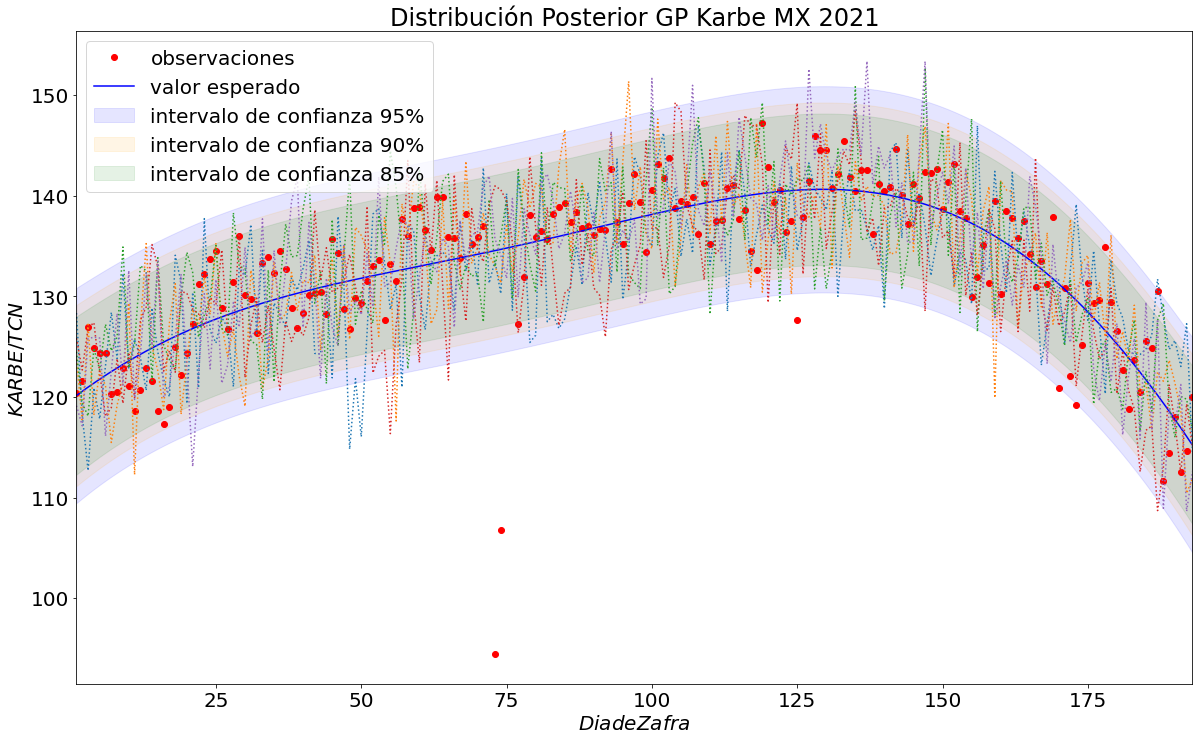

In [5]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 193, 193), ndmin = 2).T
f_mean, f_var = gp_2021.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X, y, 'ro', label='observaciones')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 193, 193), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_2021.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
#plt.ylim(70, 130)
plt.legend(loc='upper left')
plt.title('Distribución Posterior GP Karbe MX 2021')
plt.show()


### KARBE Año 2022

In [6]:
# Specify observations
df_2022 = df_all[df_all['Zafra'] == 2022]
df_2022 = df_2022.drop(df_all[df_all['KARBE/TCN'] == 0].index)
y = df_2022['KARBE/TCN'].values
X = np.array(df_2022['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 2.0e2)) + WK(10)
gp_2022 = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_2022.fit(X, y)
summary(gp_2022)

Fitted Kernel(Optimized)

99.1**2 * RBF(length_scale=156) + WhiteKernel(noise_level=22.6)

log marginal likelihood: -501.68810



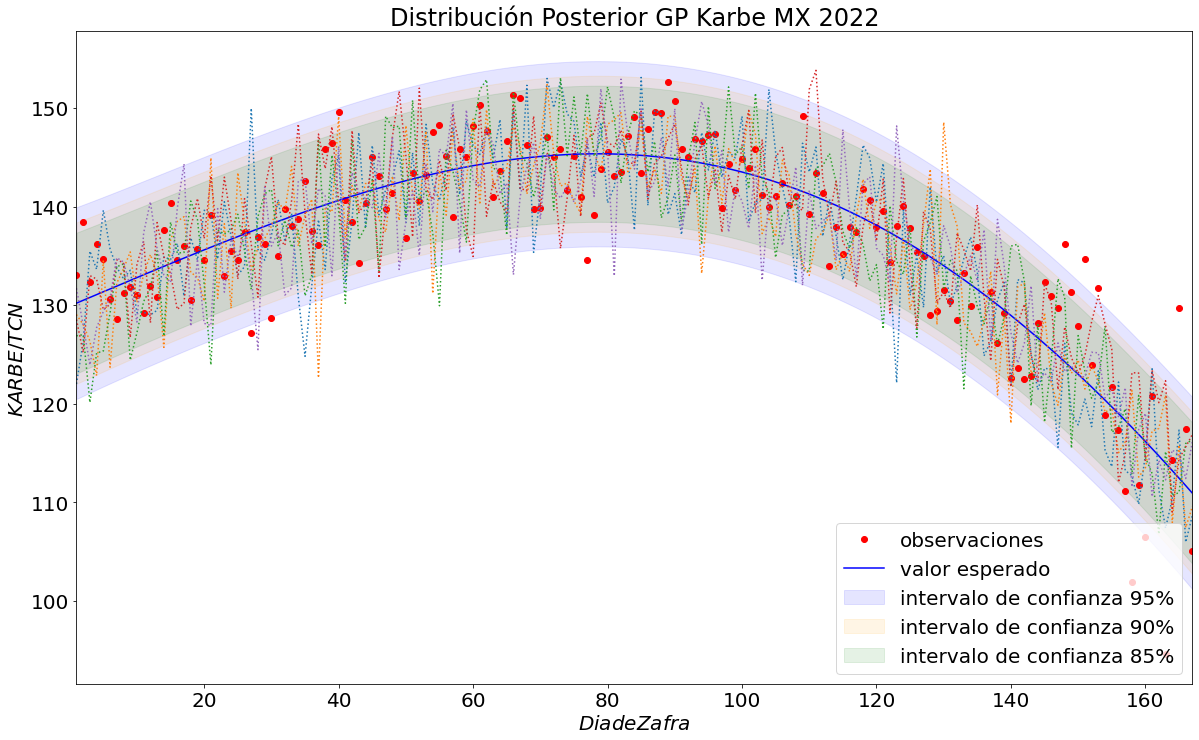

In [7]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 167, 167), ndmin = 2).T
f_mean, f_var = gp_2022.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X, y, 'ro', label='observaciones')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')


# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 167, 167), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_2022.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
#plt.ylim(70, 150)
plt.legend(loc='lower right')
plt.title('Distribución Posterior GP Karbe MX 2022')
plt.show()

### KARBE ALL YEARS

In [8]:
# Specify observations
df_todos = df_all
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022) | (df_all['Zafra'] == 2021)]
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022)]

df_todos = df_todos.drop(df_todos[df_todos['KARBE/TCN'] == 0].index)
y = df_todos['KARBE/TCN'].values
X = np.array(df_todos['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 3e2)) + WK(1)
gp_todos = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_todos.fit(X, y)
summary(gp_todos)

Fitted Kernel(Optimized)

87.2**2 * RBF(length_scale=233) + WhiteKernel(noise_level=49.9)

log marginal likelihood: -1455.68200



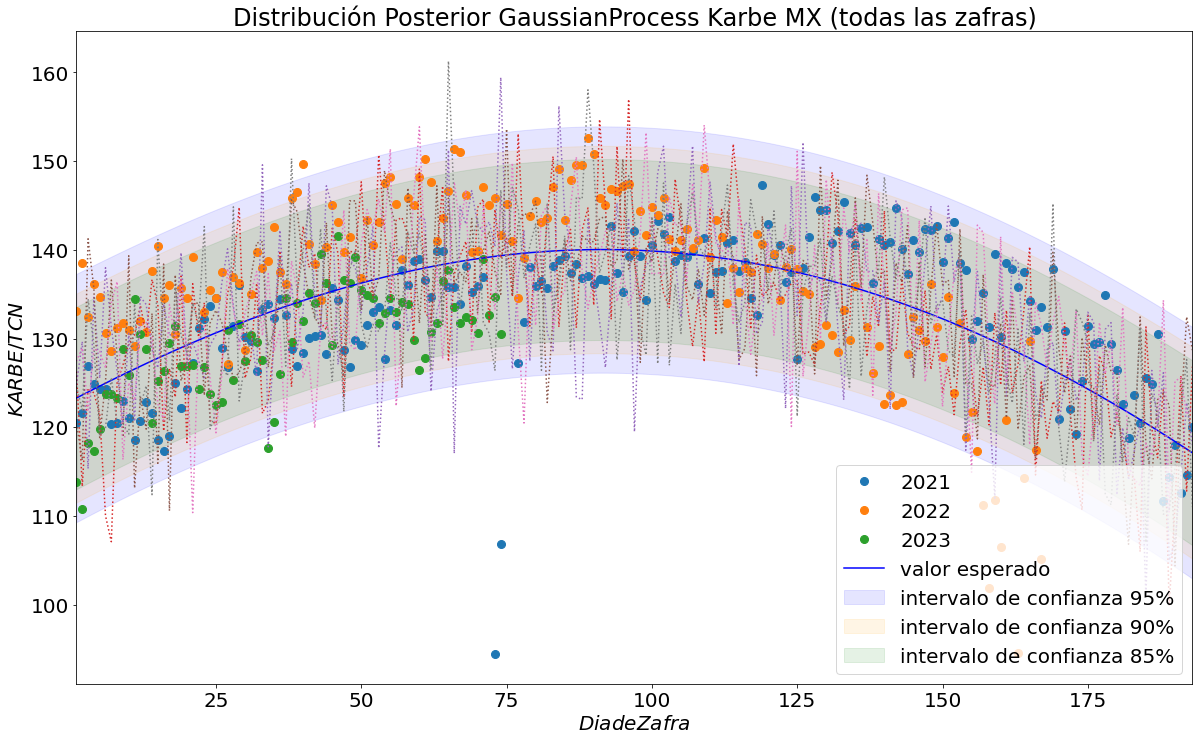

In [9]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 193, 193), ndmin = 2).T
f_mean, f_var = gp_todos.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
X_plot = df_todos['Dia Zafra']
y_plot = df_todos['KARBE/TCN']
labels = df_todos['Zafra']
df_plot = pd.DataFrame(dict(x=X_plot, y=y_plot, label=labels))
groups = df_plot.groupby('label')

# Plot
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 193, 193), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_todos.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='lower right')
plt.title('Distribución Posterior GaussianProcess Karbe MX (todas las zafras)')
plt.show()

### KARBE/TCN Final

In [10]:
# Specify observations
df_KTCN = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022) | (df_all['Zafra'] == 2021)]

df_KTCN = df_KTCN.drop(df_KTCN[df_KTCN['KARBE/TCN'] == 0].index)
y = df_KTCN['KARBE/TCN'].values
X = np.array(df_KTCN['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 3e2)) + WK(1)
gp_KTCN = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_KTCN.fit(X, y)
summary(gp_KTCN)
print("R2:",gp_KTCN.score(X, y))

Fitted Kernel(Optimized)

87.2**2 * RBF(length_scale=233) + WhiteKernel(noise_level=49.9)

log marginal likelihood: -1455.68200

R2: 0.38043694364712477


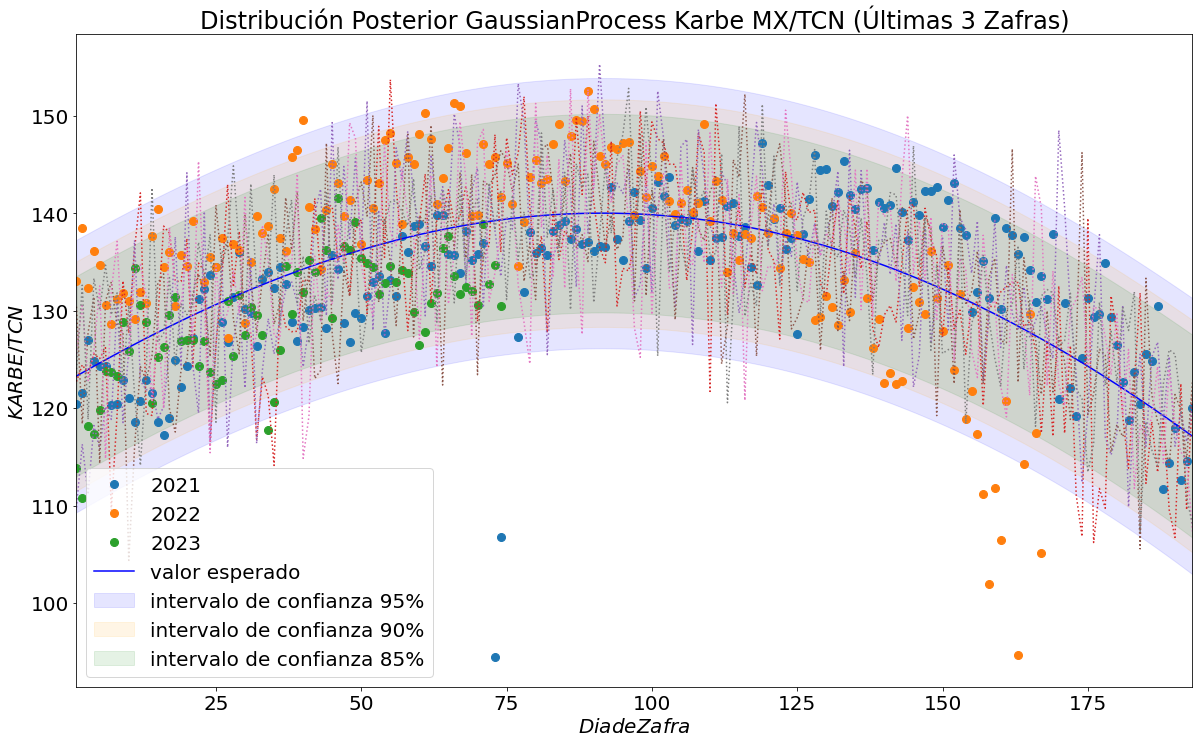

In [11]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 193, 193), ndmin = 2).T
f_mean, f_var = gp_KTCN.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
X_plot = df_KTCN['Dia Zafra']
y_plot = df_KTCN['KARBE/TCN']
labels = df_KTCN['Zafra']
df_plot = pd.DataFrame(dict(x=X_plot, y=y_plot, label=labels))
groups = df_plot.groupby('label')

# Plot
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 193, 193), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_KTCN.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='lower left')
plt.title('Distribución Posterior GaussianProcess Karbe MX/TCN (Últimas 3 Zafras)')
plt.show()

Finalmente, se exporta el resultado de los pronósticos por día de zafra a un archivo CSV de salida.

In [12]:
# Generate Data
data_tcn = {'Dia Zafra': np.arange(1,194),
        'Pronostico KARBE/TCN': f_mean,
        'Desviacion Estandar KARBE/TCN': f_var,
        'LI_95:': f_mean - 1.96*f_var,
        'UI_95:': f_mean + 1.96*f_var,
        'LI_90:': f_mean - 1.65*f_var,
        'UI_90:': f_mean + 1.65*f_var,
        'LI_85:': f_mean - 1.44*f_var,
        'UI_85:': f_mean + 1.44*f_var
       }

# Create DataFrame
df_salida = pd.DataFrame(data_tcn)
df_salida

,Dia Zafra,Pronostico KARBE/TCN,Desviacion Estandar KARBE/TCN,LI_95:,UI_95:,LI_90:,UI_90:,LI_85:,UI_85:
0,1,123.298474,7.139125,109.305788,137.291159,111.518917,135.078030,113.018133,133.578814
1,2,123.637541,7.134145,109.654616,137.620465,111.866201,135.408880,113.364372,133.910710
2,3,123.973949,7.129486,110.000156,137.947742,112.210296,135.737602,113.707489,134.240409
3,4,124.307667,7.125134,110.342405,138.272930,112.551196,136.064138,114.047474,134.567860
4,5,124.638665,7.121073,110.681362,138.595968,112.888895,136.388436,114.384320,134.893010
...,...,...,...,...,...,...,...,...,...
188,189,118.816594,7.198841,104.706865,132.926323,106.938506,130.694682,108.450263,129.182926
189,190,118.397440,7.206979,104.271762,132.523119,106.505925,130.288955,108.019391,128.775490
190,191,117.974863,7.215577,103.832331,132.117394,106.069160,129.880565,107.584431,128.365294
191,192,117.548890,7.224655,103.388565,131.709214,105.628208,129.469571,107.145386,127.952393


In [13]:
# Print the output.
df_salida.to_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Karbe\Prediccion_KarbeTCN_Mante.csv')